In [98]:
# Built-in imports
import os
import sys
import random

# Image processing imports
import cv2

# Machine learning imports
import numpy as np; print('NUMPY Version:{}'.format(np.__version__))
import pandas as pd; print('PANDAS Version:{}'.format(pd.__version__))
import tensorflow as tf; print('TENSORFLOW Version:{}'.format(tf.__version__))

# Visualization imports
import matplotlib.pyplot as plt

NUMPY Version:1.21.5
PANDAS Version:1.4.2
TENSORFLOW Version:2.9.1


In [99]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 10

DATA_DIR = 'data0/'
train_dir = os.path.join(DATA_DIR, 'training/')
test_dir = os.path.join(DATA_DIR, 'validation/')

# Attempt at deterministic outputs(Reproducibility)
def seed_it_all(seed=7):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    #rng = np.random.default_rng(seed)
    
seed_it_all()

In [100]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    # On google colab (tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR'], pass tpu_address as param in below fn)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    #If no TPU, uncomment below to check for GPU
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [101]:
num_train = len(os.listdir(train_dir))


print("Total train images:{}".format(num_train))

print('\n')

num_test = len(os.listdir(test_dir))


print("Total test images:{}".format(num_test))

Total train images:2


Total test images:2


In [102]:
def display_multiple_img(image_dir, rows, cols):
    """
    Function to Display Images from Dataset.
    
    parameters: image_dir(string) - Path of directory with images
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8))
    for ind,image_path in enumerate(os.listdir(image_dir)):
        image = cv2.imread(image_dir + image_path, -1)
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_xlabel(image.shape)
        except:
            continue;
        
    plt.tight_layout()
    plt.show()

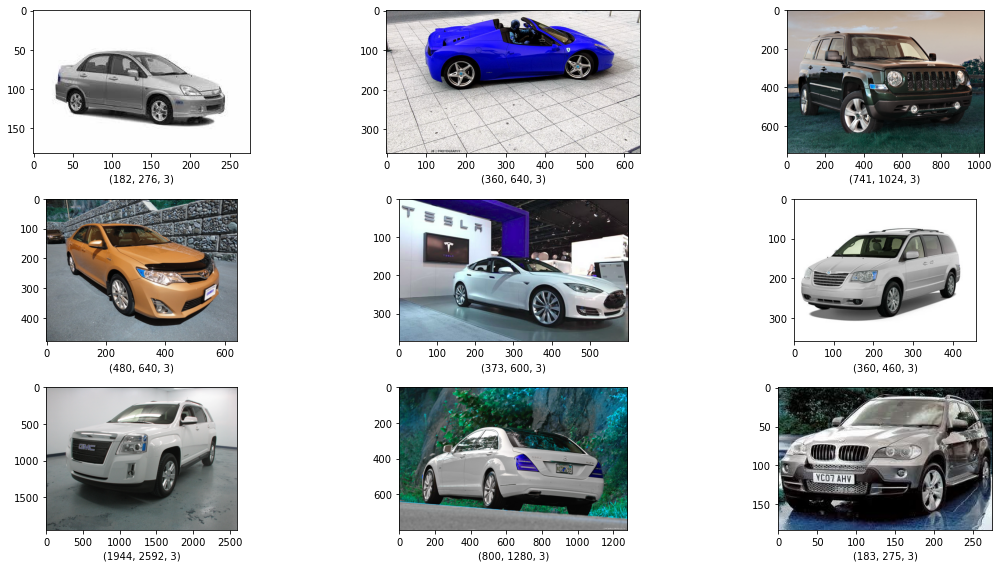

In [20]:
# Display damaged cars
display_multiple_img(train_dir, 3, 3)

In [103]:
testing_data = []
CATEGORIES=['Car', 'Not_Car']
IMG_SIZE=300
import os
import cv2
from tqdm import tqdm
def create_testing_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(test_dir,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  
                # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                testing_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_testing_data()

print(len(testing_data))

100%|███████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 453.04it/s]

736


In [141]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                  rotation_range=40,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(train_dir,
                                          target_size=(IMG_SIZE,IMG_SIZE),
                                          batch_size = BATCH_SIZE,
                                          class_mode = 'categorical',
                                          subset='training')

validation_generator = train_datagen.flow_from_directory(
                                            train_dir,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            subset='validation')
                                         
test_dataset = test_datagen.flow_from_directory(test_dir,
                                          shuffle=True,
                                          target_size=(IMG_SIZE,IMG_SIZE),
                                          batch_size = BATCH_SIZE,
                                          class_mode = 'categorical')

test_dataset.class_indices

Found 6265 images belonging to 2 classes.
Found 1565 images belonging to 2 classes.
Found 736 images belonging to 2 classes.


{'Car': 0, 'Not_Car': 1}

In [123]:
####################TEST################
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import RMSprop,Adam as Adam

In [142]:
####################TEST################
def build_model():
    model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')
    for layer in model.layers[:-2]:
        layer.trainable = False
        predictions = Dense(2, activation="softmax")(model.output)
        model_final = Model(inputs=model.input, outputs=predictions)
    return model_final

model_final = build_model()
# compile the model
model_final.compile(loss="binary_crossentropy", optimizer= Adam(lr = 0.00005), metrics=["accuracy"])

C:\Users\cdma_pc\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [148]:
####################TEST################
checkpoint = ModelCheckpoint("Car_OR_Not.h5", monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False,
                             mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [149]:
####################TEST################
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
           classes=np.unique(train_dataset.classes), 
           y=train_dataset.classes)
class_weights

array([0.95415778, 1.05046948])

In [150]:
####################TEST################
model_final.fit(
    train_dataset,
    steps_per_epoch = train_dataset.samples // 16,
    epochs = 5,
    validation_data=validation_generator,
    validation_steps = validation_generator.samples // 16,
    workers=16,
    callbacks=[checkpoint, early])

Epoch 1/5
391/391 [==============================] - ETA: 0s - loss: 0.5958 - accuracy: 0.7188
Epoch 1: val_loss improved from inf to 0.41667, saving model to Car_OR_Not.h5
391/391 [==============================] - 783s 2s/step - loss: 0.5958 - accuracy: 0.7188 - val_loss: 0.4167 - val_accuracy: 0.8949
Epoch 2/5
391/391 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.9156
Epoch 2: val_loss improved from 0.41667 to 0.26281, saving model to Car_OR_Not.h5
391/391 [==============================] - 749s 2s/step - loss: 0.3734 - accuracy: 0.9156 - val_loss: 0.2628 - val_accuracy: 0.9610
Epoch 3/5
391/391 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.9482
Epoch 3: val_loss improved from 0.26281 to 0.19087, saving model to Car_OR_Not.h5
391/391 [==============================] - 738s 2s/step - loss: 0.2714 - accuracy: 0.9482 - val_loss: 0.1909 - val_accuracy: 0.9678
Epoch 4/5
391/391 [==============================] - ETA: 0s - loss: 0.2181 -

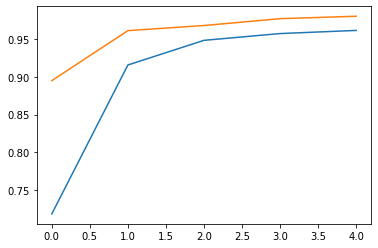

In [151]:
####################TEST################
import seaborn as sns
loss=pd.DataFrame(model_final.history.history)
plt.plot(loss['accuracy'])
plt.plot(loss['val_accuracy'])

In [152]:
####################TEST################
Xtest = []
ytest = []

for features,label in testing_data:
    Xtest.append(features)
    ytest.append(label)
Xtest = np.array(Xtest).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Xtest = Xtest/255.0
ytest=np.array(ytest)
from tensorflow.keras.utils import to_categorical
ytest = to_categorical(ytest,2)
pred=model_final.predict(Xtest)
y_classes = pred.argmax(axis=-1)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(ytest.argmax(axis=-1), y_classes))
accuracy_score(ytest.argmax(axis=-1), y_classes)

23/23 [==============================] - 39s 1s/step
[[454   2]
 [  7 273]]


0.9877717391304348

In [159]:
import tkinter as tk
from tkinter import filedialog
import imutils
from tkinter import *
from PIL import ImageTk, Image
from tensorflow.keras.preprocessing import image
import numpy as np
import numpy
import cv2
import operator
marge=70
#load the trained model to classify sign
from tensorflow.keras.models import load_model
model = load_model('Car_OR_Not.h5')
face_cascade=cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
profile_cascade=cv2.CascadeClassifier("haarcascade_profileface.xml")

In [154]:
classes= ['Car', 'Not_Car']

In [155]:
#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Cars')
top.configure(background='#CDCDCD')

label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)

In [156]:
def classify(file_path):
    global label_packed
    img = image.load_img(file_path, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classe = model.predict(x)
    print(classe)
    result = np.squeeze(classe)
    print(result)
    result_indices = np.argmax(result)
    print(result_indices)
    sign = "{}    ||   {:.2f}%".format(classes[result_indices],result[result_indices]*100)
    print(sign)
    label.configure(foreground='#011638', text=sign) 
classify_b1 =Button(top)
classify_b =Button(top)
def show_classify_button1():
    global classify_b1
    classify_b.place_forget()
    classify_b1=Button(top,text="Stop Record",command=stopp,padx=10,pady=5)
    classify_b1.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
    classify_b1.place(relx=0.79,rely=0.65)
def show_classify_button(file_path):
    global classify_b
    classify_b=Button(top,text="Classify Image",command=lambda: classify(file_path),padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)
def stopp():
    global cap
    sign_image.place_forget()
    cap.release()
def upload_image():
    global i
    i=0
    classify_b1.destroy()

    try:

        file_path=filedialog.askopenfilename()
        print(file_path)
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass

cap = None
i=0

In [157]:
upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.place(x=250,y=550)
#*********
#*********

#*********
#*********
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Car or Not Car",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

C:/Users/cdma_pc/CDMA Solutions/Damaged car/car-damage-detection/data1a/validation/01-whole/00001.jpg
1/1 [==============================] - 1s 1s/step
[[0.99748105 0.00251891]]
[0.99748105 0.00251891]
0
Car    ||   99.75%
C:/Users/cdma_pc/CDMA Solutions/car-damage-detective/data0/training/Not_Car/2.jpg
1/1 [==============================] - 0s 136ms/step
[[0.00193764 0.9980623 ]]
[0.00193764 0.9980623 ]
1
Not_Car    ||   99.81%
